# Quantum - SAT 

In this notebook we are going to use qiskit, in particular with its implementation of the
Grover algorithm, in order to solve general instances of the satisfiability problem. 

In the same directory we have also an implementation of Grover that is able to solve the Exactly-1 3-SAT problem; instead, 
with this notebook we want to study the most general case as it can be compared with its respective classical 
counterpart.

In [8]:
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg'
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle

To define the SAT problem qiskit uses the DIMACS-CNF format that allows to provide the clauses
of the problem after having first specified some parameters.

In the following lines we define input_3sat to be the file where the SAT instance is specified, while the following
lines are:

- Lines starting with c are comments
- The first non-comment line specifies:
    - cnf tells that the input is in CNF
    - nbvar is the exact number of variables appearing in the file
    - nbclauses is the exact number of clauses contained in the file
- Then we have a line for each clause ending with a 0

The input_3sat file contains the specification of a 4-SAT problem with 6 clauses formally specified as follows:

\begin{equation}
    X \equiv \{ x_1, x_2, x_3, x_4 \} : set \; of \; literals
    \\
    C \equiv \{ C_1, C_2, C_3, C_4, C_5, C_6 \} : set \; of \; clauses
\end{equation}

\begin{equation}
    C_1 = \{ \neg x_1, \neg x_2, \neg x_3, \neg x_4 \} \\
    C_2 = \{ x_1, x_2, x_3, x_4 \} \\
    C_3 = \{ \neg x_1, \neg x_2 \} \\
    C_4 = \{ \neg x_3, \neg x_4 \} \\
    C_5 = \{ \neg x_1, x_2 \} \\
    C_6 = \{ \neg x_3, x_4 \} \\
\end{equation}

In [9]:
input_3sat = '''
c example DIMACS-CNF 4-SAT
p cnf 4 6
-x1 -x2 -x3 -x4 0
x1 x2 x3 x4 0
-x1 -x2 0
-x3 -x4 0
-x1 x2 0
-x3 x4 0
'''

In this way we are allowed to define SAT problems that have unlimited number of literals and clauses
and use qiskit's Grover oracle to solve the problem.

In [10]:
oracle = LogicalExpressionOracle(input_3sat)
grover = Grover(oracle)

We have now defined an oracle using our SAT problem as input and created a Grover instance with
this oracle. Thanks to qiskit we are now already able to configure a simulator backend and run
the Grover instance to find the result:

In [11]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])

[-1, 2, -3, 4]


The result printed shows the most probable assignment that makes the problem satisfiable on the simulated circuit built
to solve this instance. As we can trivially see in the clauses formulated, there are clearly other satisfying solutions.
To find all the solutions of the problem we can plot the histogram of all the measurements carried out during the 
quantum experiment and take the results with the highest probabilities as other possible assignment solutions.

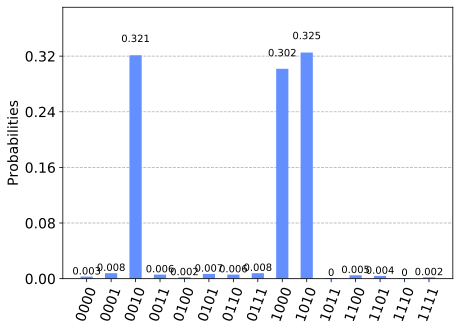

In [12]:
plot_histogram(result['measurement'])

As we can see from the histogram above the problem has 3 solutions in total, hence there are 3 possible assignments that
make the formulation satisfiable:

\begin{equation}
    a_1 = \{ \neg x_1, x_2, \neg x_3, \neg x_4 \} \\
    a_2 = \{ \neg x_1, \neg x_2, \neg x_3, x_4 \} \\
    a_3 = \{ \neg x_1, x_2, \neg x_3, x_4 \} \\
\end{equation}

## Computational Complexity
As it is precisely described in the final report we have now achieved the quadratic speedup that Grover's algorithm is
able to provide to a general instance of the k-SAT problem, in our specific example we saw the 4-SAT.

Nowadays classical solvers are able to achieve an exponential complexity around
$\mathcal{O}(1.30704^{n})$ and $\mathcal{O}(1.3303^{n})$ (where n is the number of variables/literals) respectively with 
randomized and derandomized solutions.

Thanks to randomization we can achieve in quantum computers a quadratic speedup achieved by running the
amplitude amplification used in Grover's algorithm. The randomized algorithms that I studied for k-SAT that run in time
$\mathcal{O}(T(n)poly(n))$ (where $T(n)$ is an exponentially growing function of n) actually do something stronger. 
These algorithms are based on a polynomial time algorithm that outputs the satisfying assignments, if one exists, with 
probability at least $1/T(n)$. Hence if we run the poly-algorithm all the times needed in order to find the 
possible assignments that make the problem satisfiable we will get a randomized algorithm for k-SAT that runs in time
$\mathcal{O}(T(n)poly(n))$.

Instead of running this algorithm $\mathcal{O}(T(n))$ times we can use the technique of amplitude amplification on this 
poly-time algorithm. Amplitude amplification is a generalization of the idea behind the Grover's search algorithm that 
allows to decide if an algorithm accepts with probability 0 or $1/T$ running it only the $\mathcal{O}(\sqrt{T})$ of the
times.

In conclusion, applying amplitude amplification to a k-SAT solver will introduce a quadratic speedup yielding to a final
complexity of $\mathcal{O}(\sqrt{T(n)}poly(n))$ which is quadratically faster than the one from which we started.

## Conclusions
Thanks to Grover's algorithm we have achieved a quadratic speedup in the most general case of a k-SAT problem of an
arbitrary number of clauses. Moreover we run the algorithm on the simulator, it would be interesting to see what changes
on a real quantum device that have noise and imperfect gates. However, due to the restriction on the length of the
strings that can be sent to real devices, at the moment the above circuit can not be run on a real quantum computer.
After all we can see how it is compiled on the real device using qiskit's transpiler class from an existing backend:

In [13]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')

Credentials are already in use. The existing account in the session will be replaced.


In [14]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
grover_compiled = transpile(result['circuit'], backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  OrderedDict([('cx', 523), ('u3', 204), ('u1', 93), ('u2', 45), ('measure', 4), ('barrier', 2)])
depth =  472
